In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pytensor import config as ptconf

ptconf.cxx = ""
ptconf.linker = "py"

import pymc as pm
import arviz as az


# Bayesian Hierarchial Logistic Model

## Player Foul-Commit Skill

We model the probability that a player commits a foul using a Bayesian hierarchical logistic regression. This captures each player's individual foul-committing skill while borrowing strength across all players to handle variability in player sample sizes.

**Model Specification**

We define a hierarchical logistic regression model as follows:

**Likelihood**

Each observed event \( $i$ \) has a binary outcome:

$
y_i \sim \text{Bernoulli}(p_i), \quad \text{where} \quad p_i = \text{logistic}(\eta_i)
$

The linear predictor \( $\eta_i$ \) is modeled as:

$
\eta_i = \beta_0 + \beta_{\text{minute}} \cdot minute\_norm_i + \beta_{\text{home}} \cdot is\_home_i + \beta_{\text{zone}[z_i]} \cdot zone_i + u_{\text{player}[j[i]]}
$

**Priors**

- *Global intercept and slopes*: $\beta_0 \sim \mathcal{N}(0, 2), \beta_{\text{minute}} \sim \mathcal{N}(0, 1), \beta_{\text{home}} \sim \mathcal{N}(0, 1), \beta_{\text{zone}[z]} \sim \mathcal{N}(0, 1), \quad \text{for each zone } z$


- *Player-level random intercepts*:
$
u_{\text{player}[j]} \sim \mathcal{N}(0, \sigma_{\text{player}}), \quad \text{for player } j
$

- *Hyperprior for player variability*:
$
\sigma_{\text{player}} \sim \text{Half-Cauchy}(0, 1)
$

**Interpretation of Player Skill**

The parameter $ u_{\text{player}[j]} $ quantifies the "foul-commit skill" of player \( $j$ \). Specifically:

- A positive $ u_{\text{player}[j]} $ indicates that player $ j $ has an above-average propensity to commit fouls.
- A negative $ u_{\text{player}[j]} $ indicates a below-average foul-committing propensity.

Due to the hierarchical structure, players with fewer touches (smaller samples) are "shrunk" towards the league average (partial pooling), stabilizing their estimated foul skill.

**Posterior Estimation**

We estimate this model using Variational Inference (ADVI), resulting in approximate posterior distributions from which we extract player-specific foul skills:

$
player\_foul\_skill[j] = \mathbb{E}[u_{\text{player}[j]} \mid data]
$

In [2]:
match_df = pd.read_csv('epl_matches_15.csv')

In [3]:
events_df = pd.read_csv("processed_data/events.csv")
events_df['type.name'].value_counts()

/var/folders/xz/9p327hsj39n6prk52zdm1x4h0000gn/T/ipykernel_20973/4109943820.py:1: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  events_df = pd.read_csv("processed_data/events.csv")


type.name
Pass                 368619
Ball Receipt*        340324
Carry                276949
Pressure             115402
Ball Recovery         40943
Duel                  32290
Clearance             21645
Block                 14839
Dribble               13721
Goal Keeper           11777
Miscontrol            10786
Dispossessed          10520
Shot                   9908
Foul Committed         9512
Foul Won               9112
Interception           8920
Dribbled Past          8771
Half Start             1520
Half End               1520
Starting XI             760
Referee Ball-Drop       272
Offside                 109
Own Goal For             38
Own Goal Against         38
Name: count, dtype: int64

In [4]:
events_df = events_df[
    ~events_df['type.name'].isin(
        ['Half Start','Half End','Starting XI','Referee Ball Drop','Offside','Goal Keeper','Own Goal','Own Goal Against']
    )
]

In [6]:
events_df['is_foul_committed'] = (events_df['type.name'] == 'Foul Committed').astype(int)
events_df.is_foul_committed.value_counts()

is_foul_committed
0    1288547
1       9512
Name: count, dtype: int64

In [7]:
events_df.columns

Index(['Unnamed: 0', 'id', 'index', 'period', 'timestamp', 'minute', 'second',
       'possession', 'player_possession', 'duration', 'related_events',
       'location', 'under_pressure', 'counterpress', 'type.id', 'type.name',
       'possession_team.id', 'possession_team.name', 'play_pattern.id',
       'play_pattern.name', 'team.id', 'team.name', 'tactics.formation',
       'tactics.lineup', 'player.id', 'player.name', 'position.id',
       'position.name', 'pass.length', 'pass.angle', 'pass.height.id',
       'pass.height.name', 'pass.body_part.id', 'pass.body_part.name',
       'pass.type.id', 'pass.type.name', 'pass.outcome.id',
       'pass.outcome.name', 'pass.receipient.id', 'pass.recipient.name',
       'pass.end_location', 'dribble.outcome.id', 'dribble.outcome.name',
       'ball_receipt.outcome.id', 'ball_receipt.outcome.name',
       'carry.end_location', 'duel.outcome.id', 'duel.outcome.name',
       'competition_id', 'match_id', 'is_foul_won', 'is_foul_committed'],
    

In [8]:
# parse location string into floats

def parse_loc(loc):
    if isinstance(loc, str):
        x_str, y_str = loc.split(",")
        return float(x_str), float(y_str)
    return np.nan, np.nan

events_df[['x','y']] = events_df['location'].apply(lambda loc: pd.Series(parse_loc(loc)))

In [9]:
# merge match information onto events
events_df = events_df.drop('location', axis=1)
events_df = events_df.merge(
    match_df[
        [
            'match_id','home_team.home_team_id','match_week',
            'home_team.managers', 'away_team.managers',
            'referee.id', 'referee.country.id'
        ]
    ]
    , on='match_id'
    , how='left'
)

In [11]:
events_df = events_df.drop('location', axis=1)

In [12]:
# home/away
events_df['is_home'] = (events_df['possession_team.id'] == events_df['home_team.home_team_id']).astype(int)
# match week
events_df['match_week'] = events_df['match_week'].astype(int)
# time features
events_df['minute'] = events_df['minute'].astype(int)
events_df['time_remaining'] = 90 - events_df['minute']
# approximate stoppage time flag
events_df['is_stoppage_time'] = (
    ((events_df['period'] == 1) & (events_df['minute'] > 45)) |
    ((events_df['period'] == 2) & (events_df['minute'] > 90))
)
# phase of play
events_df['phase_of_play'] = pd.cut(
    events_df['minute'],
    bins=[-1, 15, 45, 75, np.inf],
    labels=['Early','First_half','Second_half','Endgame']
)
# normalized and squared minute
events_df['minute_norm'] = (events_df['minute'] - events_df['minute'].mean()) / events_df['minute'].std()
events_df['minute_sq'] = events_df['minute_norm'] ** 2
# discretize location into grid
n_x_bins = 6
n_y_bins = 4
penalty_box_depth= 16.5
events_df['zone_x'] = pd.cut(events_df['x'], bins=n_x_bins, labels=False)
events_df['zone_y'] = pd.cut(events_df['y'], bins=n_y_bins, labels=False)
events_df['zone_id'] = events_df['zone_x'] * n_y_bins + events_df['zone_y']
# zone type thirds
third = n_x_bins // 3
events_df['zone_type'] = pd.cut(
    events_df['zone_x'],
    bins=[-1, third-1e-6, 2*third-1e-6, n_x_bins],
    labels=['Defensive','Midfield','Attacking']
)
# side of pitch
events_df['side_of_pitch'] = events_df['zone_y'].map(
    lambda y: 'Left' if y == 0 else
              'Right' if y == n_y_bins-1 else
              'Center'
)
# distance to opponent’s goal (normalize by max x)
max_x = events_df['x'].max()
events_df['distance_to_goal'] = (max_x - events_df['x']) / max_x
# penalty area flag
events_df['is_penalty_area'] = events_df['x'] >= (max_x - penalty_box_depth)

In [13]:
events_df['player_code'] = pd.Categorical(events_df['player.id']).codes
events_df['team_code'] = pd.Categorical(events_df['team.id']).codes
events_df['ref_code'] = pd.Categorical(events_df['referee.id']).codes

model_df = (
    events_df
    .loc[:, ['is_foul_committed',
           'minute_norm', 'is_home',
           'zone_id',
           'player_code', 'team_code']]
    .dropna()
    .reset_index(drop=True)
    .rename(columns={'is_foul_committed': 'y'})
)

In [14]:
coords = {
    "obs_id": model_df.index.values,
    "zone": np.unique(model_df['zone_id']),
    "player": np.unique(model_df['player_code']),
    "team": np.unique(model_df['team_code'])
}

y        = model_df['y'].values
minute   = model_df['minute_norm'].values
is_home  = model_df['is_home'].values
zone     = model_df['zone_id'].astype(int).values
p_idx    = model_df['player_code'].values
# t_idx    = model_df['team_code'].values

with pm.Model(coords=coords) as foul_commit_model:
    # Fixed effects
    β0       = pm.Normal("β0", 0, 2)
    β_minute = pm.Normal("β_minute", 0, 1)
    β_home   = pm.Normal("β_home",   0, 1)
    β_zone   = pm.Normal("β_zone",   0, 1, dims="zone")

    # Hyper‑priors
    σ_player = pm.HalfCauchy("σ_player", 1)
    # σ_team   = pm.HalfCauchy("σ_team",   1)

    # Non‑centred random intercepts
    z_p = pm.Normal("z_player", 0, 1, dims="player")
    # z_t = pm.Normal("z_team",   0, 1, dims="team")
    u_p = pm.Deterministic("u_player", z_p * σ_player)   # player foul‑commit skill
    # v_t = pm.Deterministic("u_team",   z_t * σ_team)     # team defensive style

    # Linear predictor
    η = (
        β0
      + β_minute * minute
      + β_home   * is_home
      + β_zone[zone]
      + u_p[p_idx]
      # + v_t[t_idx]
    )

    # Likelihood
    pm.Bernoulli("obs", logit_p=η, observed=y, dims="obs_id")

    # 3. ADVI (fast approximate posterior)
    approx = pm.fit(
        n=1000,                   # more iterations for stability
        method="advi",
        obj_optimizer=pm.adam(learning_rate=5e-3),
        random_seed=42
    )
    trace_comm = approx.sample(500)

Finished [100%]: Average Loss = 2.0401e+05


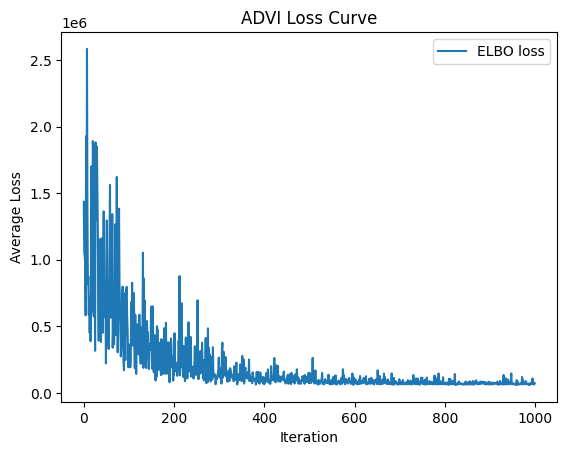

In [20]:

plt.plot(approx.hist, label="ELBO loss")
plt.xlabel("Iteration")
plt.ylabel("Average Loss")
plt.title("ADVI Loss Curve")
plt.legend()
plt.show()

In [21]:
az.summary(
    trace_comm
    , var_names=["β0","β_minute","β_home","σ_player"]
    , round_to=3
)

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β0,-1.437,0.472,-2.339,-0.593,0.023,0.016,431.383,461.604,NaN
β_minute,0.020,0.347,-0.575,0.652,0.018,0.013,355.492,453.360,NaN
β_home,-1.143,0.463,-2.095,-0.330,0.023,0.016,413.266,353.277,NaN
σ_player,1.722,0.980,0.446,3.349,0.046,0.032,459.316,407.545,NaN


In [22]:
player_commit_skill = (
    pd.DataFrame(
        {
            "player_code": coords["player"],
            "player_commit_skill": trace_comm.posterior['u_player'].mean(dim=('chain','draw')).values
        }
    )
)

player_commit_skill.to_csv("processed_data/player_foul_commit_skill.csv")
az.to_netcdf(trace_comm, "bayesian_models/player_foul_skill_trace.nc")

'bayesian_models/player_foul_skill_trace.nc'

# Players Ranked By Foul Skill

In [34]:
player_commit_skill.sort_values('player_commit_skill', ascending=True)

,player_code,player_commit_skill
388,387,-2.171493
461,460,-2.168131
423,422,-2.128338
123,122,-2.118403
192,191,-2.114660
...,...,...
356,355,-0.683725
294,293,-0.654762
521,520,-0.602639
297,296,-0.326147


In [2]:
player_commit_skill = pd.read_csv("processed_data/player_foul_commit_skill.csv")
events_df = pd.read_csv("processed_data/events.csv")

/var/folders/xz/9p327hsj39n6prk52zdm1x4h0000gn/T/ipykernel_31294/195672260.py:2: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  events_df = pd.read_csv("processed_data/events.csv")


In [3]:
player_commit_skill.head()

,Unnamed: 0,player_code,player_commit_skill
0,0,-1,-1.726600
1,1,0,-1.631009
2,2,1,-1.623046
3,3,2,-1.396845
4,4,3,-1.561307


In [4]:
player_commit_skill.shape

(550, 3)

In [14]:
events_df['player_code'] = pd.Categorical(events_df['player.id']).codes
player_info = events_df[['player_code','player.name','position.name']].drop_duplicates(
    subset=['player_code','player.name','position.name'], keep='first'
)

In [17]:
player_info = player_info.sort_values('player_code').reset_index(drop=True)
player_commit_skill = player_commit_skill.sort_values('player_code').reset_index(drop=True)

player_commit_skill['player_name'] = player_info['player.name']
player_commit_skill['player_position'] = player_info['position.name']

In [18]:
player_commit_skill.head()

,level_0,index,Unnamed: 0,player_code,player_commit_skill,player_name,player_position
0,0,0,0,-1,-1.726600,NaN,NaN
1,1,1,1,0,-1.631009,Bertrand Isidore Traoré,Left Wing Back
2,2,2,2,1,-1.623046,Bertrand Isidore Traoré,Right Defensive Midfield
3,3,3,3,2,-1.396845,Bertrand Isidore Traoré,Center Attacking Midfield
4,4,4,4,3,-1.561307,Bertrand Isidore Traoré,Right Wing


In [21]:
player_commit_skill.sort_values('player_commit_skill',ascending=False)[['player_name','player_position','player_commit_skill']].head(20)

,player_name,player_position,player_commit_skill
478,Kurt Happy Zouma,Right Back,-0.231646
297,Tom Carroll,Center Forward,-0.326147
521,Willian Borges da Silva,Right Midfield,-0.602639
294,Tom Carroll,Right Defensive Midfield,-0.654762
356,Kyle Naughton,Right Wing,-0.683725
487,Jack Frank Porteous Cork,Center Defensive Midfield,-0.720607
352,Kyle Naughton,Right Wing Back,-0.733785
526,James Philip Milner,Left Wing,-0.789893
322,Marko Arnautović,Left Wing,-0.808795
289,Kieran Trippier,Right Wing Back,-0.830019


The hierarchical model identifies wide defenders/wingers and defensive midfielders as the most foul-prone roles, with certain individuals (e.g., Fàbregas, Matić) standing out for tactical fouling despite playing in possession-oriented teams. Positive-skill (below-average fouling) players are absent from this tranche, indicating the table shows only the “highest-risk” cohort.

Beyond the values, looking at the player names and their positions does show that even though our bayesian model is a bit naive, it is able to rate players who commit fouls and are in position to commit fouls higher.